## Project: Computer simulation of a roadblock model of translational control
## Author: Gabin ROUSSEAU

#### Function arguments:

**t = time (number of iterations)**

**a = first site loading probability**

**b = final site unloading probability**

**p = site transition probability**

**L = length of the lattice**

**l = length of a particle passed in the lattice**

**State of an individual site** of index i = **Si** (i=1, ..., L)
With S = {1 if occupied, 0 if empty}

_**Note:** The state of occupation refers to a particle's tracked site exclusively, and the exclusion principle will take that into account to allow passage from one site to another. If all sites blocked by a particle were considered "occupied", it would cause problems when counting the particles on the lattice, especially if the model will end up having to qualify particle types._

**pi = probability of hopping from site i to site i+1** (for i=1,...,L-1) = assumed to be constant here. Should be equal to 1 for phase diagram testing!


Site states will be grouped in the **configuration array C = [S1,..., SL]**

Hopping probabilities will be grouped in the **progression arrary P = [p1,...,pL-1]**


---
_roadblock_ini - v0.3_

In [234]:
###############################################################################
#
#       roadblock_ini (rini) v0.3
#                               January 2024
#
#       Author: Gabin Rousseau
#
###############################################################################

#rini dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random


import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import csv

#rini_I dependecy
from sklearn.linear_model import LinearRegression
#rini_AvB dependency
import statistics

#to wrap around iterables to display a progress bar
from tqdm import tqdm

In [292]:
#Core function for the model
def rini(t=100, L=30, l=1, a=0.75, b=0.75, p=1):
    '''
    
    roadblock_ini v0.3 
    (rini for short)
    
    DESCRIPTION:
    This is the third version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process self-adapts.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t: number of iterations to run the TASEP model; DEFAULT: t=100
    L: lattice length;                              DEFAULT: L=30
    l: particle length;                             DEFAULT: l=1
    a: probability of loading;                      DEFAULT: a=0.75
    b: probability of unloading;                    DEFAULT: b=0.75
    p: probability of scanning (i.e., site hopping);DEFAULT: p=1
    
    CHANGELOG:
    Changed formulaism to one matching the Gillespie algorithm, for a non-discrete timeline of events that are randomly determined in order and temporal spacing by a,b and p.
       
    
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    P=[] #Site hopping probabilities
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    
    #exclusion rule variables
    acondition=C[0:l]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1



                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION
                particles=[index for index in range(len(C)) if C[index] == 1]

                #load-ready?
                if C[0]==0:
                    if acondition==C[0:l]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    else:
                        if particle <= L-l-1:
                            if C[particle+l]==0:
                                A[particle]=p
                            else:
                                A[particle]=0                                
                        else:
                            A[particle]=p
            
                #update dataset
                rini_data.setdefault('time', []).append(time)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

In [261]:
#create a function that returns an initiation rate estimate
#for starters, calculate regression from time point t=L (to eliminate the expected phase of scanning for an uninterrupted first particle where the first initiation has yet to occur)
#note to self: exit flow: total exit count divided by time, might be even more relevant with Gillespie
def rini_I(t=100, L=30, l=1, a=0.75, b=0.75, p=1):
    '''
    rini_I for rini v0.3
    Estimates the initiation rate of the rini model as the simple exit current J=max(passed_total)/t.
    '''
    #Define the rini model run with the input parameters
    rini_data=rini(t,L,l,a,b,p) 
    
    I=max(rini_data['passed_total'])/max(rini_data['time'])
    
        
    return round(I,2)

In [192]:
#Plots changes in exit rate over time
def rini_IvAB(t=100, L=30, l=1, a=1, b=1, p=1, a_range=np.arange(0,1,0.02), b_range=np.arange(0,1,0.02), out=False):
    '''
    For rini v0.2
    Measures I against a range of alpha values and beta values respectively. In either case, a default value for the other parameter is set (default:0.75).
    Plots the comparison in two separate figures.
    The user can specify the range of values considered in addition to the base rini parameters in the form of numpy.arange() arrays.
    Optionally returns the dataset used for plotting.
    '''
    #open data dictionary
    IvAB={'alpha':[],'I_a':[], 'beta':[],'I_b':[]}
    
    #Tie initiation rates to variable alpha or beta values
    for alpha in a_range:
        IvAB.setdefault('alpha', []).append(alpha)
        IvAB.setdefault('I_a', []).append(rini_I(t, L, l, alpha, b, p))
    for beta in b_range:
        IvAB.setdefault('beta', []).append(beta)
        IvAB.setdefault('I_b', []).append(rini_I(t, L, l, a, beta, p))
    #convert to pandas dataframe
    IvAB_data= pd.DataFrame(data=IvAB)
    
    #plot
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.lineplot(x='alpha', y='I_a', data=IvAB_data)
    plt.xlabel('Alpha')
    plt.ylabel('Initiation rate')
    
    plt.subplot(122)
    sns.lineplot(x='beta', y='I_b', data=IvAB_data)
    plt.xlabel('Beta')
    plt.ylabel('Initiation rate')
    
    plt.tight_layout()
    plt.show();
    
    if out==True:
        print('Dataset returned.')
        return IvAB_data
        

In [194]:
#Plots the phase diagram
def rini_AvB(t=500, L=100, l=1, p=1, randomised=False, n=10):
    '''
    For rini v0.2
    Plots alpha against beta. By default, plots 3 points expected to fit the respective density phases of TASEP and prints the median lattice occupation density over each point.
    If the 'randomised' argument is set to True, a selectable amount of points (n) will be made for random combinations of a and b.
    '''
    #open data dictionary
    AvB={'alpha':[], 'beta':[], 'med_d':[]}
    
    if randomised==False:
        #prepare 3 points for LD, HD, and MC scenarios in order
        combi=[[0.25,0.75],[0.75,0.25],[0.75,0.75]]
        for a, b in combi:
            median_density=statistics.median(rini(t, L, l, a, b, p)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('med_d', []).append(median_density)
                        
    elif randomised==True:
        for i in range(n):
            a=round(random.uniform(0.1,1),2)
            b=round(random.uniform(0.1,1),2)
            median_density=statistics.median(rini(t, L, l, a, b, p)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('med_d', []).append(median_density)
            
        
        
    
    #convert to pandas dF
    AvB_data= pd.DataFrame(data=AvB)
    #plot
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.scatterplot(x='alpha', y='beta', data=AvB_data)
    #frame the phases
    plt.plot([0,0.5], [0,0.5], color='r')
    plt.plot([0.5,0.5], [0.5,1.0], color='r')
    plt.plot([0.5,1.0], [0.5,0.5], color='r')
    
    #assign labels to points and print corresponding density
    for point in range(len(AvB_data['med_d'])):
        x=AvB_data['alpha'][point]
        y=AvB_data['beta'][point]
        density=AvB_data['med_d'][point]
        plt.text(x+0.01,y+0.01,f'{point}',size=10)
        #LOW DENSITY EXPECTED
        if x<0.5 and x<y:
            print(f'Median density ({point}) = {density}\nExpected LD bulk density: a = {x}\n\n')
        #HIGH DENSITY EXPECTED
        elif y<0.5 and y<x:
            print(f'Median density ({point}) = {density}\nExpected HD bulk density: 1-b = {1-y}\n\n')
        #MAXIMUM CURRENT EXPECTED
        elif x>0.5 and y>0.5:
            print(f'Median density ({point}) = {density}\nExpected MC bulk density: 0.5\n\n')
        else:
            print(f'Point ({point}) does not satisfy any TASEP phase condition.')
            
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    
    
    
    plt.tight_layout()
    plt.show();
    
    
    
    
    

In [283]:
#Check the output of rini
rini(t=500,l=3)

,time,passed_total,density,S1,S2,S3,S4,S5,S6,S7,...,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30
0,0.000000,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.054016,0,0.03,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.339334,0,0.03,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.690828,0,0.03,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.868793,0,0.03,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,498.886203,70,0.17,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2244,499.028398,70,0.17,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2245,499.902883,70,0.20,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2246,499.923984,70,0.20,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [263]:
#Visualise the exits over time + linear regression used to determine the rate
rini_I(t=10000)

0.26

In [265]:
#Visualise the exits + regression when a rate is severely limiting the progress of the model
rini_I(t=10000, L=30, l=1, a=0.01, b=1, p=1)

0.01

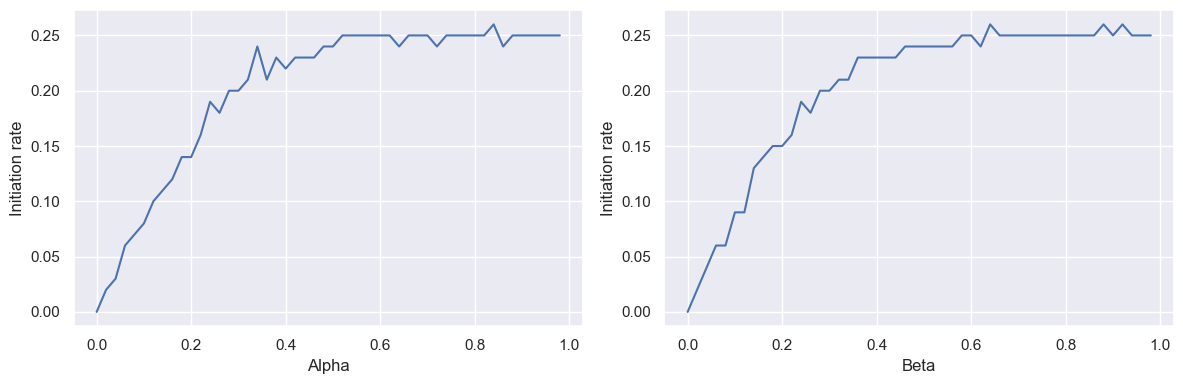

In [296]:
#Visualise changes in the initiation rate depending on either alpha or beta
#On the left, b=1; on the right, a=1
rini_IvAB(1000)

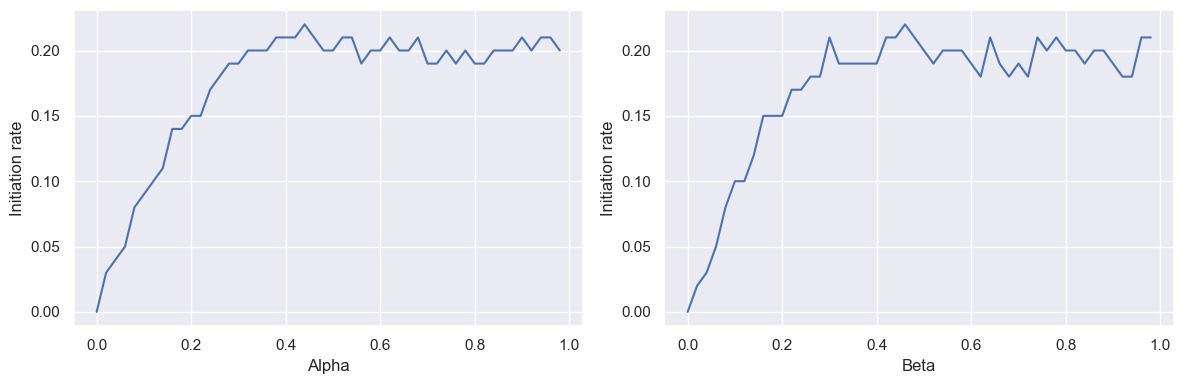

In [297]:
#Same as above but the constant rates are 0.3 instead of 1.
rini_IvAB(a=0.3,b=0.3,t=1000)

Median density (0) = 0.26
Expected LD bulk density: a = 0.25


Median density (1) = 0.74
Expected HD bulk density: 1-b = 0.75


Median density (2) = 0.5
Expected MC bulk density: 0.5




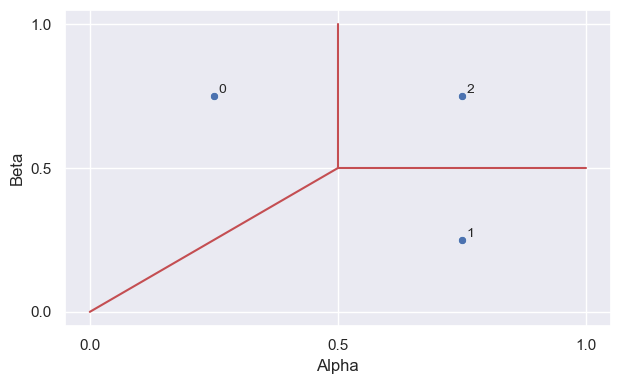

In [236]:
#Plot a phase diagram with a representative point for each phase
rini_AvB(t=10000)

Median density (0) = 0.48
Expected LD bulk density: a = 0.39


Median density (1) = 0.5
Expected MC bulk density: 0.5


Median density (2) = 0.42
Expected LD bulk density: a = 0.42


Median density (3) = 0.51
Expected MC bulk density: 0.5


Median density (4) = 0.73
Expected HD bulk density: 1-b = 0.74


Median density (5) = 0.49
Expected MC bulk density: 0.5


Median density (6) = 0.5
Expected MC bulk density: 0.5


Median density (7) = 0.67
Expected HD bulk density: 1-b = 0.6699999999999999


Median density (8) = 0.33
Expected LD bulk density: a = 0.34


Median density (9) = 0.58
Expected HD bulk density: 1-b = 0.6




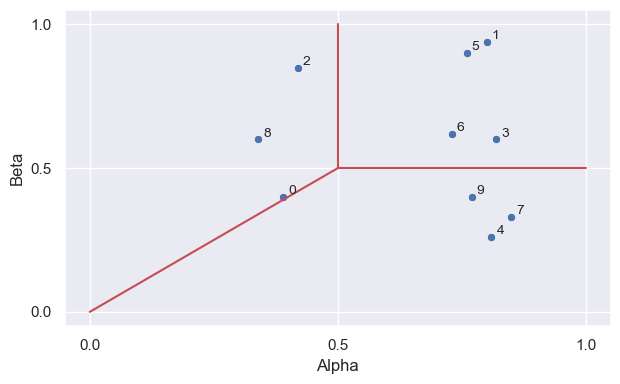

In [232]:
#Phase diagram with 10 random points
rini_AvB(randomised=True, n=10,t=10000)

In [237]:
#affix a run of rini to a variable and save the table if needed
model_test=rini()
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-3_output/table2.csv')

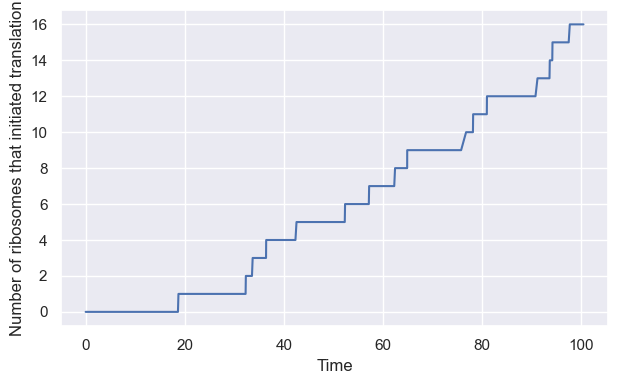

In [223]:
#INITIATED VS. TIME model_test
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='passed_total', data=model_test)

plt.xlabel('Time')
plt.ylabel('Number of ribosomes that initiated translation')

plt.tight_layout()
plt.show();

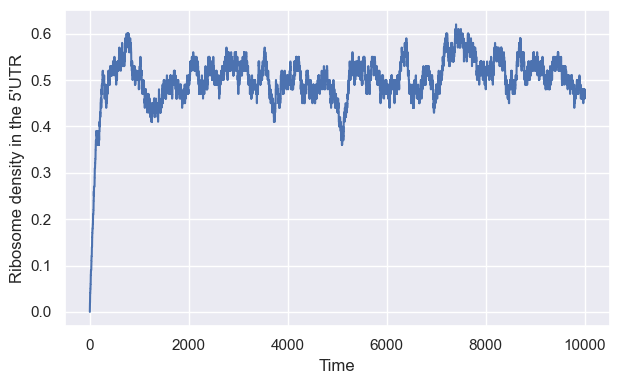

In [231]:
#DENSITY VS. TIME Max current (a and b >1/2)
#EXPECTED: d=1/2
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(t=10000, L=100))

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

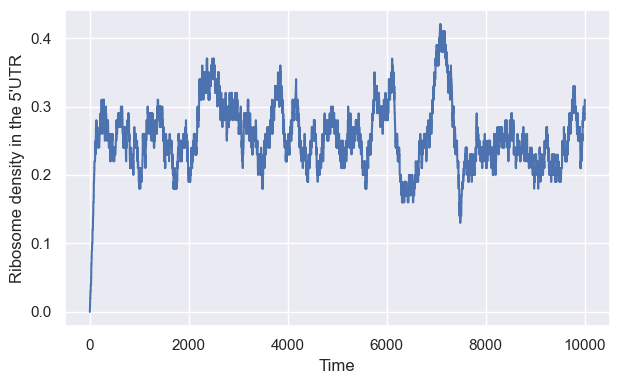

In [230]:
#DENSITY VS. TIME Low density (a < 1/2 and a < b)
#EXPECTED: d=a (0.25 here)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(a=0.25, t=10000, L=100))

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

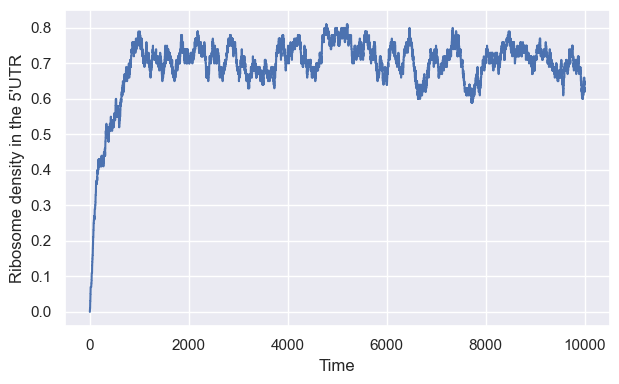

In [229]:
#DENSITY VS. TIME High density (b < 1/2 and a > b)
#EXPECTED: d=1-b (b=0.3 here so 0.7)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(b=0.3,t=10000,L=100))

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();